# Toy Model
The second notebook focuses on the Toy Model presented in the article and examines the corresponding FCNN.

In [2]:
!rm -rf sample_data Machine-Learning-Phases-of-Matter MonteCarloSampling data.csv
# Compile C source codes
!gcc -Wall MonteCarloSampling.c -o MonteCarloSampling.o -lm

In [3]:
#@markdown Load libraries and helper functions
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing {device} device")

# CONSTANTS
critical_temperature = 2/( np.log( np.sqrt(2)+1) )

# FUNCTIONS
def generate_data(lowest_temperature, increment_temperature, highest_temperature,
                  lattice_side, number_of_configurations,
                  initial_number_of_thermalisation_steps, number_of_thermalisation_steps,
                  filename='data.csv', clear_old_data=True, show_termalisation_info=False):
  # ! This version supports the "initial_number_of_thermalisation_steps" parameter
  debug_flag = "" if show_termalisation_info else "1>/dev/null"
  clear_flag = f"rm -rf {filename}" if clear_old_data else ""

  sh = f"""
  set -e
  export LC_NUMERIC="en_US.UTF-8"

  {clear_flag}

  for T in $(seq {lowest_temperature} {increment_temperature} {highest_temperature})
  do
    ./MonteCarloSampling.o --lattice-side {lattice_side} \
                          --temperature $T \
                          --number-of-configurations {number_of_configurations} \
                          --initial_thermalisation-steps {initial_number_of_thermalisation_steps} \
                          --thermalisation-steps {number_of_thermalisation_steps} \
                          --output-file '{filename}' {debug_flag}
  done
  """
  with open('script.sh', 'w') as file:
    file.write(sh)

  !bash script.sh && rm script.sh

def dataframe_from_lattice_csv(fileName, lattice_side):
  df = pd.read_csv(fileName, names=['L', 'T', 'E']+['LP'+str(i) for i in range(lattice_side*lattice_side)] )

  df['lattice'] = df[df.columns[3:]].apply( lambda x: np.array(x, dtype=np.float32), axis=1)
  df = df.drop(columns=['L']+['LP'+str(i) for i in range(lattice_side*lattice_side)])
  df['magnetization']  = df['lattice'].apply(lambda x: x.sum()/x.shape[0])

  return df



Using cpu device


## Notebook 02 - The Toy Model

Data Generation

In [4]:
lowest_temperature = 1
highest_temperature = 3.51
increment_temperature = 0.05
lattice_side = 30
number_of_configurations = 1000
initial_number_of_thermalisation_steps = 2000
number_of_thermalisation_steps = 1000
# number_of_thermalisation_steps = 4000

filename = "toy_model_data.csv"
# generate_data(lowest_temperature, increment_temperature, highest_temperature,
#               lattice_side, number_of_configurations,
#               initial_number_of_thermalisation_steps, number_of_thermalisation_steps,
#               filename, clear_old_data=True, show_termalisation_info=False)

print(f"Data Generation completed. The files are available in {filename}.")

Data Generation completed. The files are available in toy_model_data.csv.


### Analytical Toy Model
The toy model presented in the article is an analytical version of a FCNN with hand-made parameters. It consists of three layers: an input layer with $L^2$ units, a hidden layer made of three neurons with Heaviside activation function and an output layer made of two neurons. As an example, a network with eight input neurons is shown in the following figure.

<center><img src="https://i.ibb.co/7GnhrLh/download.png" alt="Toy Model" border="0"></center>


#### Hidden Layer
The weights are chosen so that the hidden layer detects whether the spins are mainly in the positive $+1$ state or the negative $-1$ state using the order parameter, namely the magnetization $m(x)= \frac{1}{N} \sum_{i=1}^{N} \sigma_i$:

$$ W_1x+b_1 = \frac{1}{N(1+\epsilon)}\begin{bmatrix}
 1 & 1 & ... &  1 \\
-1 & -1 & ... & -1 \\
 1 & 1 & ... &  1 \end{bmatrix}
\begin{bmatrix}
 \sigma_1 \\
 \sigma_2 \\
 \vdots \\
 \sigma_{L\times L}\end{bmatrix} + \frac{\epsilon}{1+\epsilon} \begin{bmatrix}
 -1 \\
 -1 \\
  1 \\
 \end{bmatrix} = \frac{1}{(1+\epsilon)} \begin{bmatrix}
 m(x)-\epsilon \\
 -m(x) - \epsilon \\
  m(x) + \epsilon \end{bmatrix}.$$

The first and second neurons activate when the state is predominantly polarized up to a threshold $\epsilon$. In other words, the first neuron detects $m(x)> \epsilon $ while the second detects if $m(x)< - \epsilon $. The third neuron activates if the state has magnetization $m(x)>-\epsilon$. In the limit $0<\epsilon << 1$ the third neuron detects whether the configuration has a positive magnetization up to a threshold $\epsilon$.

<br/> 

#### Output layer
The second set of weights is:

$$ W_2x+b_2 = \begin{bmatrix}
 2 &  1 & -1 \\
-2 & -2 &  1 \end{bmatrix} \begin{bmatrix}
 \theta(W_1 x+b_1)_1 \\
 \theta(W_1 x+b_1)_2 \\
 \theta(W_1 x+b_1)_3  \end{bmatrix} + \begin{bmatrix}
 0 \\
 0 \end{bmatrix}$$

The second choice of parameters allows the Toy model to be a phase detector. If the system is mainly in a polarized state, either positive or negative, the first element of the output vector will be positive ($+1$). On the contrary, if the system is not in a well-defined state the second entry will be positive. Notice how the second entry can detect if the system is in a positive or negative phase. 

<br/> 

#### Parameters of the Toy Model
In the article the following parameters are chosen:
- Side of the lattice: $L=30$
- Free parameter $\epsilon$: unspecified
- Temperature range: unspecified

In [5]:
def toy_model(lattice, epsilon):
  N = lattice_side*lattice_side
  W_1 = np.ones( (3, N) )
  W_1[1] = -1*W_1[1]
  W_1 = 1/(N*(1+epsilon))* W_1
  b_1 = epsilon/(1+epsilon) * np.array([[-1], [-1], [1]])
  W_2 = np.array([ [ 2,  1, -1],
                   [-2, -2,  1] ])

  hidden_layer_input = W_1 @ lattice[:,  np.newaxis] + b_1  
  hidden_layer_output = np.heaviside(hidden_layer_input, 1)
  output_layer = W_2 @ hidden_layer_output
  output = np.heaviside(output_layer, 1)
  
  return hidden_layer_input, hidden_layer_output, output_layer, output

 Plot of the analytical toy model as a function of $\epsilon$.


/tmp/ipykernel_435073/3284057309.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=df['magnetization'], y=hidden_layer_input[:, 0], ax=ax[0], label=r"$\uparrow$", ci=None)
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

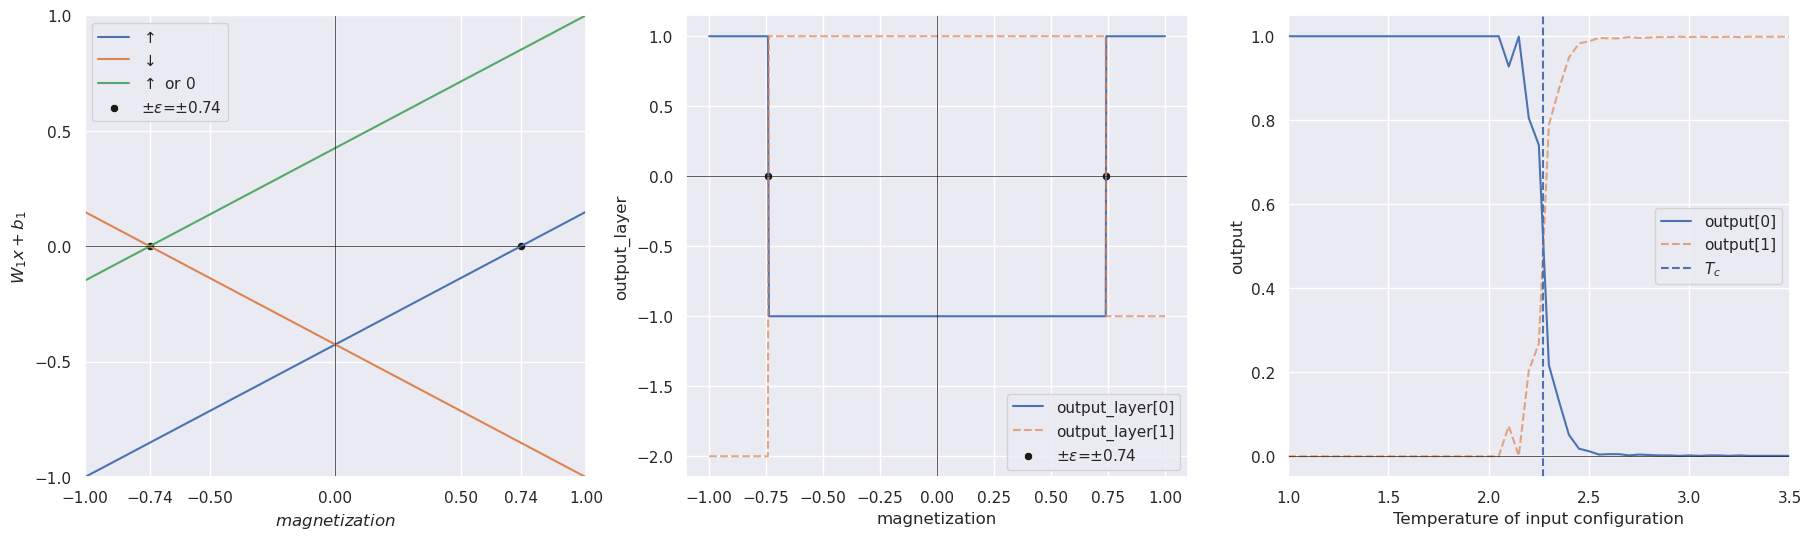

In [6]:
epsilon = 0.74

# Import data
df = dataframe_from_lattice_csv('toy_model_data.csv', lattice_side)
N = lattice_side*lattice_side
N_configurations = df.shape[0]

# Empty vectors
hidden_layer_input  = np.empty( (N_configurations, 3) )
hidden_layer_output = np.empty( (N_configurations, 3) )
output_layer = np.empty( (N_configurations, 2) )
output = np.empty( (N_configurations, 2) )

for i in range(N_configurations):
  lattice = df['lattice'][i]  # Rewrite this part wihtout using for
  output_tuple = toy_model(lattice, epsilon)

  hidden_layer_input[i]  = output_tuple[0].flatten()
  hidden_layer_output[i] = output_tuple[1].flatten()
  output_layer[i] = output_tuple[2].flatten()
  output[i] = output_tuple[3].flatten()


# Actual plots
def plot_cartesian_axis(ax):
  ax.axhline(y=0, color='k', linewidth = 0.5)
  ax.axvline(x=0, color='k', linewidth = 0.5)

sns.set_theme(rc={'figure.figsize':(22,6)}, style='darkgrid')


fig, ax = plt.subplots(1, 3)
sns.lineplot(x=df['magnetization'], y=hidden_layer_input[:, 0], ax=ax[0], label=r"$\uparrow$", ci=None)
sns.lineplot(x=df['magnetization'], y=hidden_layer_input[:, 1], ax=ax[0], label=r"$\downarrow$", ci=None)
sns.lineplot(x=df['magnetization'], y=hidden_layer_input[:, 2], ax=ax[0], label=r"$\uparrow$ or $0$", ci=None)
sns.scatterplot(x=[-epsilon, epsilon], y=[0,0], ax=ax[0],
                    color="k", marker='o',
                    label=r"$\pm\epsilon$=$\pm${:.2}".format(epsilon))

ax[0].set(xlabel=r'$magnetization$', ylabel=r'$W_1 x + b_1$',
       xticks=[-1, -0.5, -epsilon, 0, epsilon, 0.5, 1], yticks=[-1, -0.5, 0, 0.5, 1],
       xlim=[-1, 1], ylim=[-1, 1])



sns.lineplot(x=df['magnetization'], y=output_layer[:, 0], ax=ax[1],
             label=r"output_layer[0]", ci=None)
sns.lineplot(x=df['magnetization'], y=output_layer[:, 1], ax=ax[1],
             label=r"output_layer[1]", ci=None, alpha=0.7, linestyle='--')
sns.scatterplot(x=[-epsilon, epsilon], y=[0,0], ax=ax[1],
                color="k", marker='o',
                label=r"$\pm\epsilon$=$\pm${:.2}".format(epsilon))
ax[1].set_ylabel("output_layer")


sns.lineplot(x=df['T'], y=output[:, 0], ax=ax[2],
             label=r"output[0]", ci=None)
sns.lineplot(x=df['T'], y=output[:, 1], ax=ax[2],
             label=r"output[1]", ci=None, alpha=0.7, linestyle='--')
Tc = 2/( np.log( np.sqrt(2)+1) )
ax[2].axvline(Tc, 0, 1, label=r"$T_c$", linestyle="--")
ax[2].set_xlim([1, 3.5])
ax[2].set_xlabel("Temperature of input configuration")
ax[2].set_ylabel("output")

for a in ax.flatten():
  plot_cartesian_axis(a)
  a.legend();

For the value $\epsilon=0.74$ hidden layer produces three lines with an x-intercept equal to $\pm \epsilon$. The second layer as a function of the magnetization has the interpretation provided above. Once a second heavyside is applied and the results plotted as a function of the temperature the intepretation becomes clearer: the value of the first neuron $output[0]$ represents the confidence of the model of being below the critical point while the value of the second neuron $output[1]$ the confidence of being above the critical temperature. By finding the intersection of the two lines an esteem of the critical temperature can be found.

### Neural Network of the Toy Model
Instead of using TensorFlow as the authors did, I tried to use [pytorch](https://pytorch.org/). A quick introduction to the framework can be found [here](https://pytorch.org/tutorials/beginner/basics/intro.html).

#### Input data and labels
**Input data**: the input data are a one-dimensional representation of the configuration generated obtained by concatenation of the row of the lattice. As the network is fully connected there is no difference between a one-dimensional and a two-dimensional input: in both cases, all the sites are connected with all the others.  
**Labels**: labels are generated in accordance with the expected output of the Toy model:
- $\begin{bmatrix}
 1 \\
 0 \end{bmatrix}$ if $T < T_c$
- $\begin{bmatrix}
 0 \\
 1 \end{bmatrix}$ if $T > T_c$

</br> 

#### Training and Test sets
The data is first split into a training set and a test set. A complete overview of the procedure is out of scope for the project, but, in a nutshell, the procedure assures that the network can not overfit the data as its performances are evaluated over a different set. Best practices suggest the introduction of a third set called _validation_ used to measure the final performances of the network after all the hyperparameters are decided. As the hyperparameters are given by the article and it is always possible to generate new configurations using the Monte Carlo sampling, this third set was not considered.

In [7]:
from sklearn.model_selection import train_test_split

df = dataframe_from_lattice_csv('toy_model_data.csv', lattice_side)

# Input data are just the lattice sites
X = np.empty( (df['lattice'].shape[0], lattice_side*lattice_side), dtype=np.float32 )
for idx, lattice in enumerate(df['lattice']):
  X[idx] = lattice

# Y should be [0., 1.] if T>Tc or [1., 0] otherwise.
Y = np.empty( (df.shape[0], 2), dtype=np.float32)
for idx, T in enumerate(df['T']):
  Y[idx] = [0., 1.] if T>Tc else [1., 0]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=True)

Nine configurations picked at random with corresponding labels.

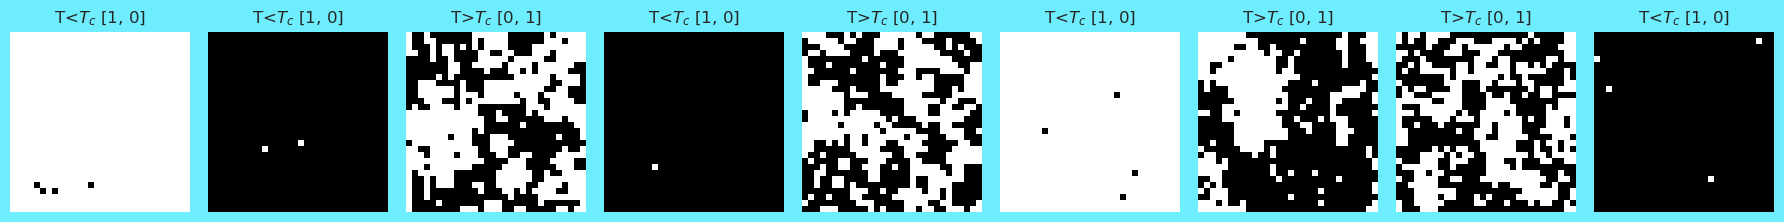

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(18, 8))
fig.patch.set_facecolor('xkcd:robin\'s egg')

for ax in axs:
  sample_idx = int(np.random.rand()*len(X_train))
  img, label = X_train[sample_idx], Y_train[sample_idx, :]
  ax.set_title(r"T{}$T_c$ [{}, {}]".format('>' if label[1] else '<',
                                          int(label[0]),
                                          int(label[1]) ))
  ax.axis("off")
  ax.imshow(img.reshape( (lattice_side, lattice_side) ), interpolation='none',
            cmap="gray")

plt.tight_layout()
plt.show();

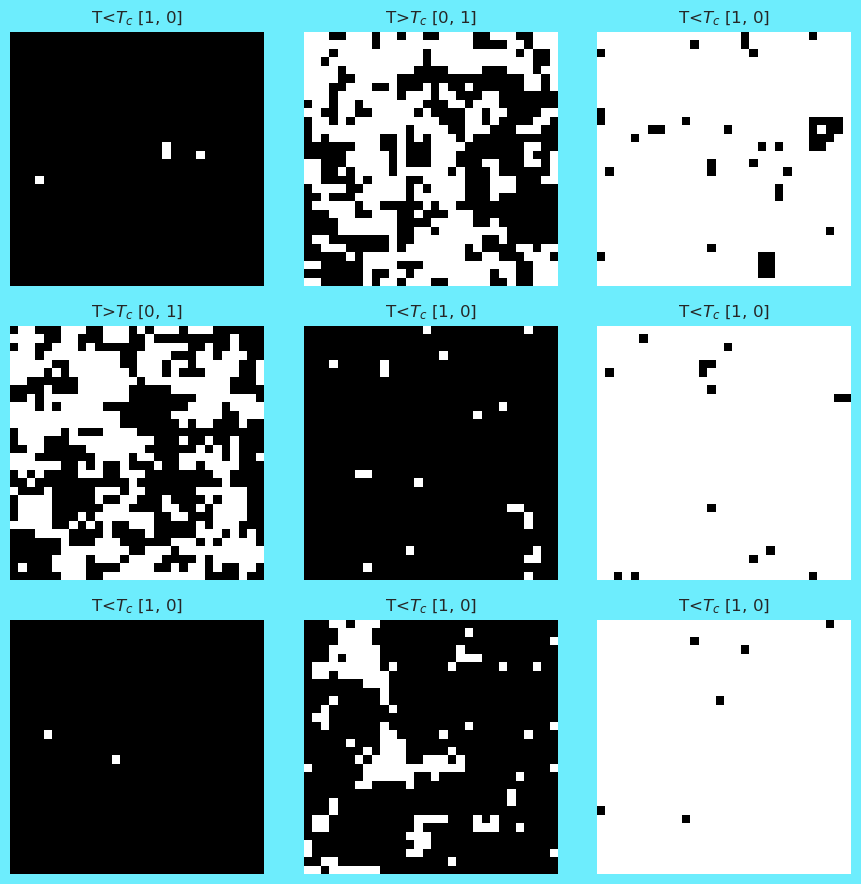

In [9]:

# Convert the code to generate figures in a 3x3 grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 9)) # Changed to 3x3 grid
fig.patch.set_facecolor('xkcd:robin\'s egg')

# Flatten the axs array for easy iteration
axs = axs.flatten()

for ax in axs:
    sample_idx = int(np.random.rand()*len(X_train))
    img, label = X_train[sample_idx], Y_train[sample_idx, :]
    ax.set_title(r"T{}$T_c$ [{}, {}]".format('>' if label[1] else '<',
                                            int(label[0]),
                                            int(label[1]) ))
    ax.axis("off")
    ax.imshow(img.reshape((lattice_side, lattice_side)), interpolation='none',
              cmap="gray")

plt.tight_layout()
plt.show();

#### The network and the train function
The network is constructed with the same structure of the toy model:
- Input layer consisting of $L^2$ neurons
- Hidden layer with 3 neurons and a **sigmoid** activation function
- Output layer with 2 neurons and a **sigmoid** activation function

The training is configured as a classification problem. For an in-depth discussion of the network refeer to the next notebook.

In [10]:
from torch import nn

class NeuralNetwork(nn.Module):  
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.hidden_layer = nn.Linear(lattice_side*lattice_side, 3, bias=True)
    self.activation = nn.Sigmoid()
    self.output_layer = nn.Linear(3, 2, bias=False)

  def forward(self, x):
    x = self.hidden_layer(x)
    x = self.activation(x)
    x = self.output_layer(x)
    x = self.activation(x)
    return x

  def forward_hidden_layer(self, x):
    return self.hidden_layer(x)

  def forward_output_layer(self, x):
    x = self.hidden_layer(x)
    x = self.activation(x)
    return self.output_layer(x)

#####################################


def train(model, X, y, epochs):
  # The Cross Entropy Loss is suitable for classification problems
  loss_function = nn.BCELoss()

  # Create an optimizer that will be used to train the network.
  # Weight decay handles the L2 regularizator
  learning_rate = 1e-2
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-05)
  
  # List of losses for visualization
  losses = []

  for i in range(epochs):
    y_pred = model.forward(X)
    loss = loss_function(y_pred, y)

    # Clear the previous gradients and compute the new ones
    optimizer.zero_grad()
    loss.backward()

    # Adapt the weights of the network
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

    # Print the results
    if i % (epochs//10) == 0 or i == epochs-1:
      print(f"Epoch {i+1} loss is {loss.item()}")

  return losses

Training and Test

Epoch 1 loss is 0.7118328213691711
Epoch 101 loss is 0.6401342749595642
Epoch 201 loss is 0.45382851362228394
Epoch 301 loss is 0.35053515434265137
Epoch 401 loss is 0.27710098028182983
Epoch 501 loss is 0.25232088565826416
Epoch 601 loss is 0.23844903707504272
Epoch 701 loss is 0.2297194004058838
Epoch 801 loss is 0.2240610122680664
Epoch 901 loss is 0.21892574429512024
Epoch 1000 loss is 0.21832230687141418
Test loss: 0.2530711889266968 



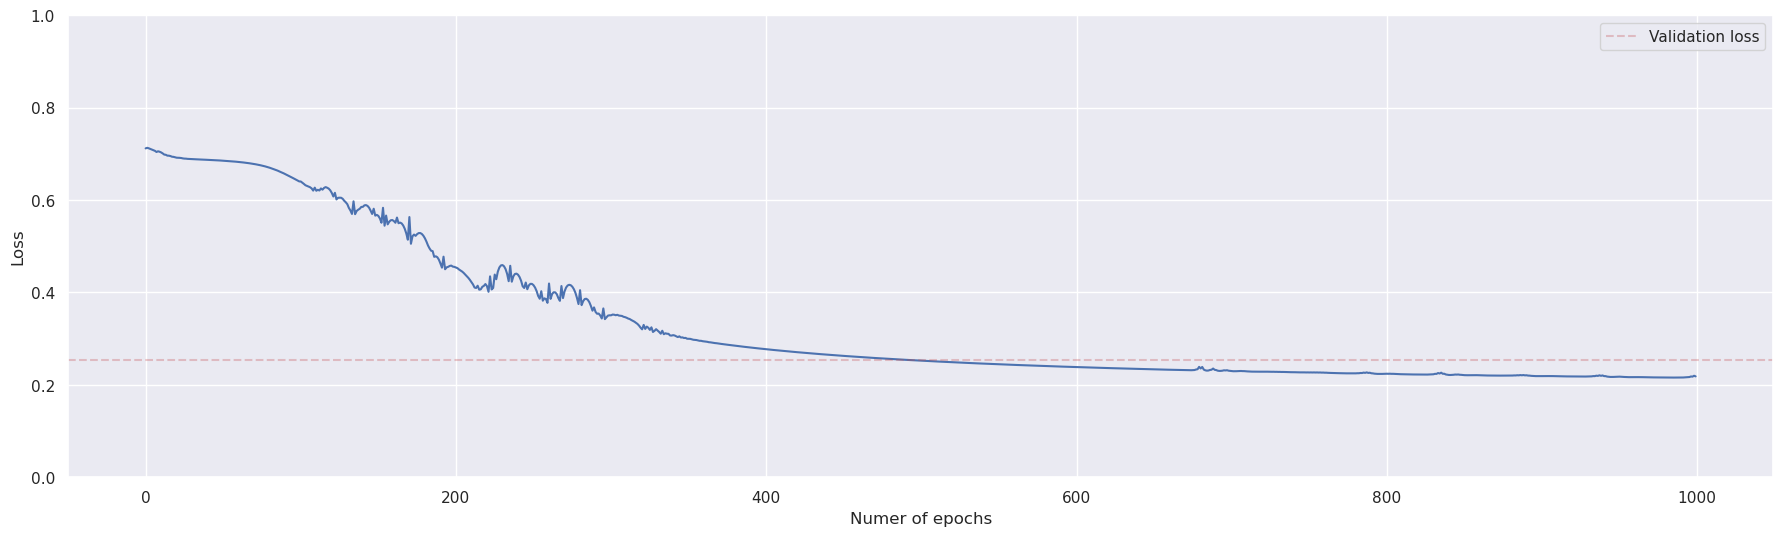

In [11]:
# Convert the 2D points to a float32 tensor
X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_torch = torch.from_numpy(Y_train).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_torch = torch.from_numpy(Y_test).to(device)

# Generate and train the model
model = NeuralNetwork().to(device)
losses = train(model, X_train_torch, Y_train_torch, epochs=1000)

# Test the model
Y_pred = model.forward(X_test_torch)
loss = nn.BCELoss()(Y_pred, Y_test_torch)
print("Test loss:", loss.item(), "\n")

# Losses plot
plt.plot(np.arange( len(losses) ), losses);
plt.axhline(y=loss.item(), color='r', linestyle='--', alpha=0.3, label="Validation loss")
plt.legend()
plt.ylim([0, 1])
plt.ylabel("Loss")
plt.xlabel("Numer of epochs");

The training of this network is not very stable and depends on the initial parameters and the stochastic component of the Adam optimizer. The following results are shown assuming a test loss lower than $0.1$. If that's not the case, please re-run the training.  
Notice that "training up to the desired result" is not very good practice, but this problem will be solved in the next notebook by increasing the number of neurons in the hidden layer as done by the authors.

Hidden and output layer as a function of the magnetization

/tmp/ipykernel_435073/4160685272.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=df['magnetization'], y=Y_input_layer[:, 0], ax=ax[0], label=r"hidden_layer[0]", ci=None)
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

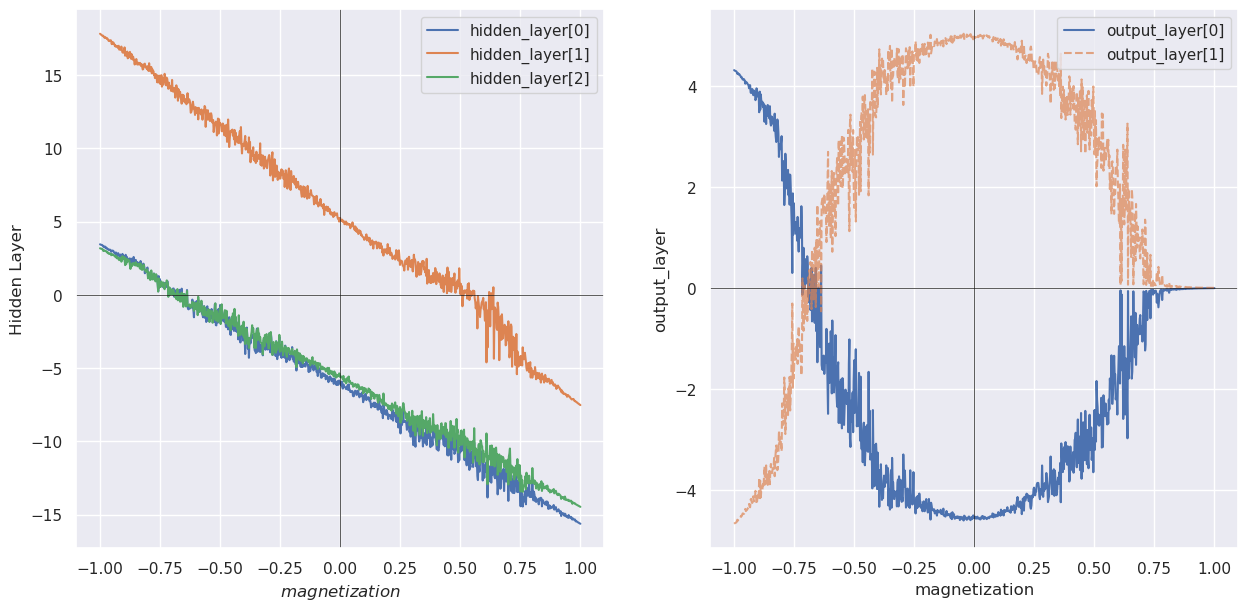

In [12]:
X_torch = torch.tensor(X, dtype=torch.float32).to(device)

Y_input_layer = model.forward_hidden_layer(X_torch).cpu().detach().numpy()
Y_hidden_layer = model.forward_output_layer(X_torch).cpu().detach().numpy()


fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.lineplot(x=df['magnetization'], y=Y_input_layer[:, 0], ax=ax[0], label=r"hidden_layer[0]", ci=None)
sns.lineplot(x=df['magnetization'], y=Y_input_layer[:, 1], ax=ax[0], label=r"hidden_layer[1]", ci=None)
sns.lineplot(x=df['magnetization'], y=Y_input_layer[:, 2], ax=ax[0], label=r"hidden_layer[2]", ci=None)
ax[0].set(xlabel=r'$magnetization$', ylabel=r'Hidden Layer')


sns.lineplot(x=df['magnetization'], y=Y_hidden_layer[:, 0], ax=ax[1], label=r"output_layer[0]", ci=None)
sns.lineplot(x=df['magnetization'], y=Y_hidden_layer[:, 1], ax=ax[1], label=r"output_layer[1]", ci=None, alpha=0.7, linestyle='--')
ax[1].set_ylabel("output_layer")

for a in ax.flatten():
  plot_cartesian_axis(a)
  a.legend();

 Output as a function of temperature

/tmp/ipykernel_435073/3632683402.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=df['T'], y=Y_detached[:, 0], ax=ax, label=r"output[0]", marker="o", ci=None)
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

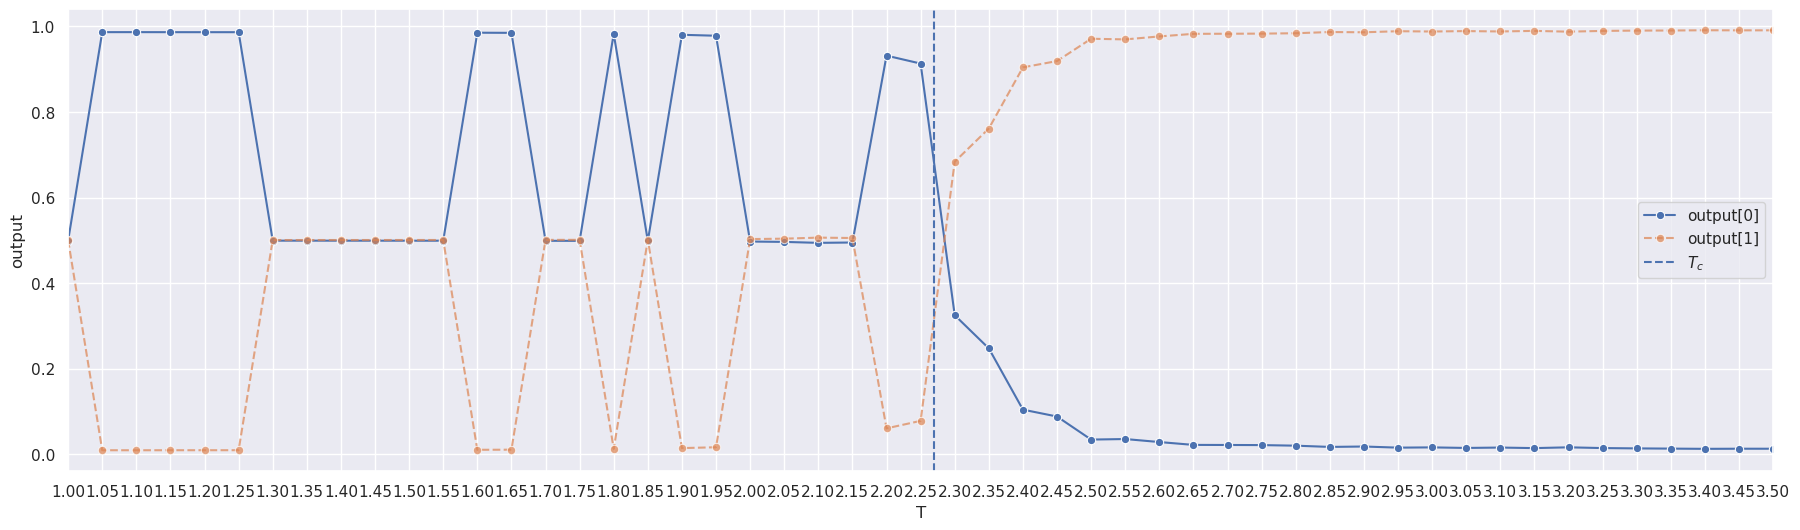

In [13]:
X_torch = torch.tensor(X, dtype=torch.float32).to(device)
Y_pred = model.forward(X_torch)
Y_detached = Y_pred.cpu().detach().numpy()

fig, ax = plt.subplots(1, 1)
sns.lineplot(x=df['T'], y=Y_detached[:, 0], ax=ax, label=r"output[0]", marker="o", ci=None)
sns.lineplot(x=df['T'], y=Y_detached[:, 1], ax=ax, label=r"output[1]", marker="o", ci=None, alpha=0.7, linestyle='--')
ax.axvline(Tc, 0, 1, label=r"$T_c$", linestyle="--")


xticks = np.arange(lowest_temperature, highest_temperature, increment_temperature)
ax.set_xticks(xticks)
ax.set_xticklabels(['{:.2f}'.format(T) for T in xticks])

ax.legend()
ax.set_xlim([1, 3.5])
ax.set_ylabel("output");

The output looks similar in shape to the one of the Toy Model. The main differences lie in the size of the first two plots. This is probably due to the change of activation function from _Heaviside_ to _Sigmoid_ (see figure below).  The first has an abrupt change from $0$ to $1$ in $x=0$ while the latter has a continuous change that starts in $x\simeq -5$ and ends in $x\simeq 5$. Notice that the continuity of the activation function is what allows the training to be performed in the first place: the gradient of the Heaviside is infinite in $x=0$ and $0$ elsewhere.  
The presence of the sigmoid can be seen in the first two plots:
- The _hidden layer_  evaluates to values ranging from well before $x=-5$ and after $x=5$ to simulate the Heaviside
- The _output layer_ resembles two sigmoids mirrored in analogy to the mirrored Heavisides in the analytical toy model.

Finally, the plot of the output as a function of the temperature, the target of our training, is correctly reproduced.

These factors, if taken into account, show that a Machine Learning Model can, indeed, distinguish the two phases of the square Ising model.

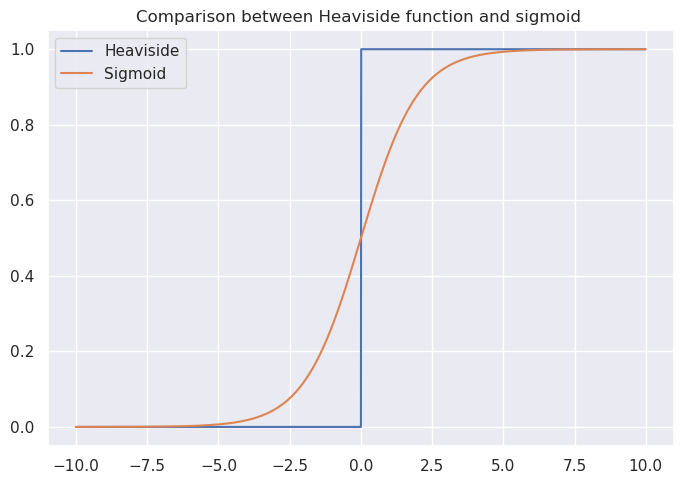

In [14]:
x = np.arange(-10, 10, 0.01)
plt.figure(figsize=(7, 5))
plt.title("Comparison between Heaviside function and sigmoid ")
plt.plot(x, np.heaviside(x, 1), label="Heaviside" )
plt.plot(x, 1/(1 + np.exp(-x)), label="Sigmoid")
plt.legend()
plt.tight_layout()
plt.show();